In [12]:
from awpy import Demo

import torch
from torch_geometric.data import DataLoader
from torch_geometric.loader import DataLoader

from torch_geometric.nn import HeteroConv, Linear, GATv2Conv

import pandas as pd
import polars as pl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import time
import json
import sys
import os

pd.set_option('display.max_columns', 100)
pd.set_option('future.no_silent_downcasting', True)

pl.Config.set_tbl_rows(10)

sys.path.append(os.path.abspath('../package'))

from CS2.graph import TabularGraphSnapshot, HeteroGraphSnapshot, TemporalHeteroGraphSnapshot
from CS2.token import Tokenizer
from CS2.preprocess import Dictionary, NormalizePosition, NormalizeTabularGraphSnapshot, ImputeTabularGraphSnapshot
from CS2.visualize import HeteroGraphVisualizer, HeteroGNNRoundAnalyzer

#### Parse match

In [3]:
# Nodes and edges dataframes
nodes = pd.read_csv('../data/map_graph_model/de_inferno/nodes_norm.csv')
edges = pd.read_csv('../data/map_graph_model/de_inferno/edges.csv')





# ----------------------------------------------------------
#           TabularGraphSnapshot, Impute, Tokenize
# ----------------------------------------------------------

# Create tabular snapshot object
tg = TabularGraphSnapshot()

df, _, active_infernos, active_smokes, active_he_smokes = tg.process_match(
    match_path='g2-vs-natus-vincere-m4-inferno.dem',
    player_stats_data_path='../data/player-stats/scraped-in-2024/2022/norm_player_stats_2022.csv',
    missing_player_stats_data_path='../data/player-stats/missing_players_df_2022.csv',
    weapon_data_path='../data/weapon_info/ammo_info.csv',

    ticks_per_second=4,
    numerical_match_id=000000,
    num_permutations_per_round=1,
    build_dictionary=True,

    package='pandas'
)

# Impute missing values
its = ImputeTabularGraphSnapshot()
df = its.impute(df)

# Tokenize match
tokenizer = Tokenizer()
df = tokenizer.tokenize_match(df, 'de_inferno', nodes)





# ----------------------------------------------------------
#                   Read config files
# ----------------------------------------------------------

# Dictionary
dictionary = pd.read_csv('../proj/graph_dataset/parses/hetero_parse-24.09.28 dictionary_2023-2024.09_2024.09.28.csv')

# Get CONFIG parameters
inferno_pos_norm_config = '../config/map_normalization/inferno.json'
molotov_radius_config = '../config/nade_radius/molotov_norm.json'
smoke_radius_config = '../config/nade_radius/smoke_norm.json'

with open(inferno_pos_norm_config, 'r') as f:
    CONFIG_INF_POS_NORM = json.load(f)
with open(molotov_radius_config, 'r') as f:
    CONFIG_MOLOTOV_RADIUS = json.load(f)
with open(smoke_radius_config, 'r') as f:
    CONFIG_SMOKE_RADIUS = json.load(f)






# ----------------------------------------------------------
#                    HeteroGraphSnapshot
# ----------------------------------------------------------

# Nodes and edges dataframes
nodes_to_use = pd.read_csv('../data/map_graph_model/de_inferno/nodes_norm.csv')
edges = pd.read_csv('../data/map_graph_model/de_inferno/edges.csv')

# Normalize active nade dataframes
np = NormalizePosition()
active_infernos = np.normalize(active_infernos, CONFIG_INF_POS_NORM)
active_smokes = np.normalize(active_smokes, CONFIG_INF_POS_NORM)
active_he_smokes = np.normalize(active_he_smokes, CONFIG_INF_POS_NORM)

# Normalize tabular snapshot
nts = NormalizeTabularGraphSnapshot()
df = nts.noramlize(df, dictionary, CONFIG_INF_POS_NORM)

# Graph snapshots
hg = HeteroGraphSnapshot()
graphs = hg.process_snapshots(df, nodes_to_use, edges, active_infernos, active_smokes, active_he_smokes, CONFIG_MOLOTOV_RADIUS, CONFIG_SMOKE_RADIUS)

Info: The output variable values are ['T', 'CT'].


#### Visualize round predictions

In [13]:
class HeterogeneousGNN(torch.nn.Module):

    # --------------------------------------------------
    # Initialization
    # --------------------------------------------------

    def __init__(self, player_dims, map_dims, dense_layers, player_attention_heads=None, map_attention_heads=None):

        super().__init__()

        if player_attention_heads is not None and len(player_dims) != len(player_attention_heads):
            raise ValueError('The length of player dimensions and player attention heads arrays must be the same.')
        if map_attention_heads is not None and len(map_dims) != len(map_attention_heads):
            raise ValueError('The length of map dimensions and map attention heads arrays must be the same.')

        self.conv_layer_number = max([len(player_dims), len(map_dims)])
        self.player_convs = len(player_dims)
        self.map_convs = len(map_dims)

        # Create convolutional layers
        self.convs = torch.nn.ModuleList()
        for conv_idx in range(self.conv_layer_number):

            layer_config = {}

            if conv_idx < len(player_dims):
                if player_attention_heads is None:
                    layer_config[('player', 'is', 'player')] = GATv2Conv((-1, -1), player_dims[conv_idx], add_self_loops=False)
                else:
                    layer_config[('player', 'is', 'player')] = GATv2Conv((-1, -1), player_dims[conv_idx], add_self_loops=False, heads=player_attention_heads[conv_idx])

            if conv_idx < len(player_dims):
                layer_config[('player', 'closest_to', 'map')] = GATv2Conv((-1, -1), map_dims[conv_idx], add_self_loops=False)

                
            if conv_idx < len(map_dims):

                # GAT
                if map_attention_heads is None:
                    layer_config[('map', 'connected_to', 'map')] = GATv2Conv((-1, -1), map_dims[conv_idx], add_self_loops=False)
                else:
                    layer_config[('map', 'connected_to', 'map')] = GATv2Conv((-1, -1), map_dims[conv_idx], add_self_loops=False, heads=map_attention_heads[conv_idx])


            conv = HeteroConv(layer_config, aggr='mean')
            self.convs.append(conv)



        # Create linear layer for the flattened input
        self.linear = Linear(-1, dense_layers[0]['input_neuron_num'])

        
        # Create dense layers based on the 'dense_layers' parameter
        dense_layers_container = []
        for layer_config in dense_layers:

            if layer_config['dropout'] == 0:
                # Add the first layer manually because it has a different input size
                dense_layers_container.append(torch.nn.Linear(layer_config['input_neuron_num'], layer_config['neuron_num']))
                
                # Add activation function if it is not None - the last layer does not have sigmoid activation function because of the BCEWithLogitsLoss
                if layer_config['activation_function'] is not None:
                    dense_layers_container.append(layer_config['activation_function'])

                # Add the rest of the layers (if there are any)
                for _ in range(layer_config['num_of_layers'] - 1):
                    dense_layers_container.append(torch.nn.Linear(layer_config['neuron_num'], layer_config['neuron_num']))

                    # Add activation function if it is not None - the last layer does not have sigmoid activation function because of the BCEWithLogitsLoss
                    if layer_config['activation_function'] is not None:
                        dense_layers_container.append(layer_config['activation_function'])
            else:
                dense_layers_container.append(torch.nn.Dropout(layer_config['dropout']))
        
        self.dense = torch.nn.Sequential(*dense_layers_container)
        





    # --------------------------------------------------
    # Forward pass
    # --------------------------------------------------

    def forward(self, x_dict, edge_index_dict, y, batch_size):

        # Do the convolutions
        conv_idx = 1
        for conv in self.convs:
            temp = conv(x_dict, edge_index_dict)
            
            if conv_idx < self.player_convs:
                x_dict['player'] = temp['player']

            if conv_idx < self.map_convs:
                x_dict['map'] = temp['map']
                
            x_dict = {key: torch.nn.functional.leaky_relu(x) for key, x in x_dict.items()}

            conv_idx += 1


        # Container for the flattened graphs after the convolutions
        flattened_graphs = []

        # Do the convolutions for each graph in the batch
        for graph_idx in range(batch_size):

            # Get the actual graph
            actual_x_dict, actual_edge_index_dict = self.get_actual_graph(x_dict, edge_index_dict, graph_idx, batch_size)

            # Get the graph data
            graph_data = torch.tensor([
                y['round'][graph_idx],
                y['time'][graph_idx],
                y['remaining_time'][graph_idx],
                y['CT_alive_num'][graph_idx],
                y['T_alive_num'][graph_idx],
                y['CT_total_hp'][graph_idx],
                y['T_total_hp'][graph_idx],
                y['CT_equipment_value'][graph_idx],
                y['T_equipment_value'][graph_idx],
                y['CT_losing_streak'][graph_idx],
                y['T_losing_streak'][graph_idx],
                y['is_bomb_dropped'][graph_idx],
                y['is_bomb_being_planted'][graph_idx],
                y['is_bomb_being_defused'][graph_idx],
                y['is_bomb_planted_at_A_site'][graph_idx],
                y['is_bomb_planted_at_B_site'][graph_idx],
                y['bomb_X'][graph_idx],
                y['bomb_Y'][graph_idx],
                y['bomb_Z'][graph_idx],
                y['bomb_mx_pos1'][graph_idx],
                y['bomb_mx_pos2'][graph_idx],
                y['bomb_mx_pos3'][graph_idx],
                y['bomb_mx_pos4'][graph_idx],
                y['bomb_mx_pos5'][graph_idx],
                y['bomb_mx_pos6'][graph_idx],
                y['bomb_mx_pos7'][graph_idx],
                y['bomb_mx_pos8'][graph_idx],
                y['bomb_mx_pos9'][graph_idx],
            ]).to('cuda')

            # Create the flattened input tensor and append it to the container
            x = torch.cat([torch.flatten(actual_x_dict['player']), torch.flatten(actual_x_dict['map']), torch.flatten(graph_data)])

            flattened_graphs.append(x)

        # Stack the flattened graphs
        x = torch.stack(flattened_graphs).to('cuda')

        x = self.linear(x)
        x = torch.nn.functional.leaky_relu(x)
        
        x = self.dense(x)
        
        return x
    






    # --------------------------------------------------
    # Helper functions
    # --------------------------------------------------

    def get_actual_graph(self, x_dict, edge_index_dict, graph_idx, batch_size):

        # Node feature dictionary for the actual graph
        actual_x_dict = {}

        single_player_node_size = int(x_dict['player'].shape[0] / batch_size)
        single_map_node_size = int(x_dict['map'].shape[0] / batch_size)

        actual_x_dict['player'] = x_dict['player'][graph_idx*single_player_node_size:(graph_idx+1)*single_player_node_size, :]
        actual_x_dict['map'] = x_dict['map'][graph_idx*single_map_node_size:(graph_idx+1)*single_map_node_size, :]


        # Edge index dictionary for the actual graph
        actual_edge_index_dict = {}

        single_map_to_map_edge_size = int(edge_index_dict[('map', 'connected_to', 'map')].shape[1] / batch_size)
        single_player_to_map_edge_size = int(edge_index_dict[('player', 'closest_to', 'map')].shape[1] / batch_size)

        actual_edge_index_dict[('map', 'connected_to', 'map')] = edge_index_dict[('map', 'connected_to', 'map')] \
            [:, graph_idx*single_map_to_map_edge_size:(graph_idx+1)*single_map_to_map_edge_size] \
            - graph_idx*single_map_node_size
        
        actual_edge_index_dict[('player', 'closest_to', 'map')] = edge_index_dict[('player', 'closest_to', 'map')] \
            [:, graph_idx*single_player_to_map_edge_size:(graph_idx+1)*single_player_to_map_edge_size]
        
        actual_edge_index_dict_correction_tensor = torch.tensor([single_player_node_size*graph_idx, single_map_node_size*graph_idx]).to('cuda')
        actual_edge_index_dict[('player', 'closest_to', 'map')] = actual_edge_index_dict[('player', 'closest_to', 'map')] - actual_edge_index_dict_correction_tensor.view(-1, 1)

        
        return actual_x_dict, actual_edge_index_dict
    


582


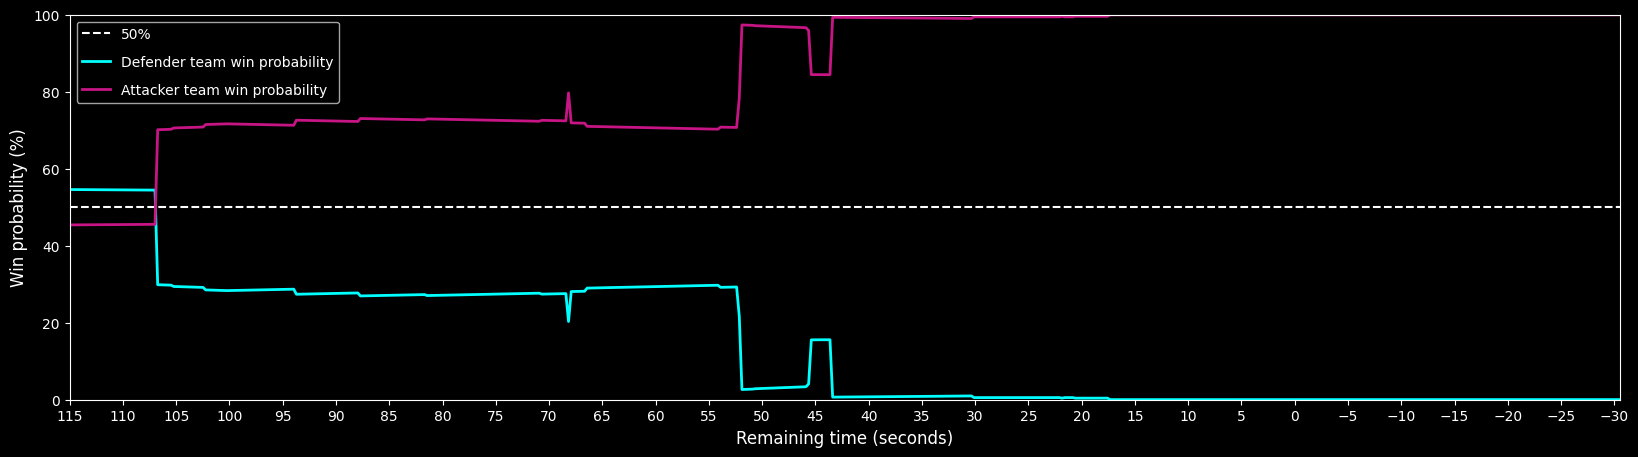

In [14]:
# Model
PATH_MODELS = '../model/gnn/'
model = torch.load(PATH_MODELS + '240930_5/epoch_3.pt', weights_only=False)

analyzer = HeteroGNNRoundAnalyzer()
analyzer.analyze_round(graphs, model, 7)